***最終Kaggle評分***

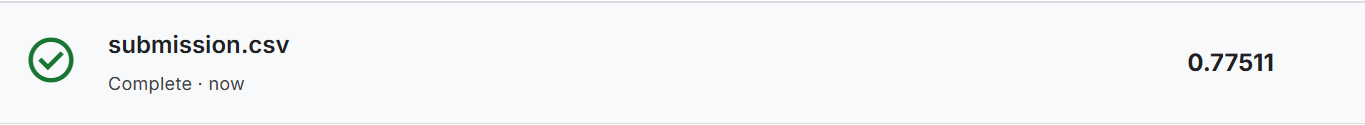

***#Prompt***

請step by step完成以下步驟並確保訓練集和測試集特徵一致，生成的提交文件包含 418 行，包含 PassengerId 和 Survived。
我想在colab上對kaggle資料Titanic - Machine Learning from Disaster用隨機森林演算法做預測
1. CRISP-DM 框架
2. get data from kaggle
3. confusion matrix
4. accuracy
5.生成csv檔並下載

特徵擷取:
1. 提取乘客姓名中的稱謂（如 Mr., Mrs. 等）
2. 用每個稱謂的年齡中位數填補缺失的年齡值。
3. 將稱謂做獨熱編碼作為新特徵添加到數據框中。
4. 將年齡分為三個區間：<16歲, 16-40歲, >40歲做label encoding。
5. 添加特徵：檢查票號的首字母是否為數字、計算家庭大小、檢查票號是否包含字母 "A"。
6. 將性別轉換為數字（男為0，女為1）。
7. 對 "Embarked" 特徵進行label encoding。
定義最終的特徵集，包括 Pclass, Sex, Fare, 及其他生成的特徵。

***#獲取數據***

In [6]:
# 安裝 kaggle 套件
!pip install kaggle

# 上傳 kaggle.json
from google.colab import files
files.upload()  # 上傳 kaggle.json

# 創建 kaggle 資料夾
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# 下載 Titanic 資料集
!kaggle competitions download -c titanic

# 解壓縮下載的檔案
!unzip titanic.zip

Saving kaggle.json to kaggle.json
titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  titanic.zip
replace gender_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


***數據清理和特徵工程***

In [7]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer

# 讀取數據
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# 定義一個函數來提取稱謂
def extract_title(name):
    title_search = re.search(r',\s*([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return None

# 提取稱謂並創建新特徵
for df in [train_df, test_df]:
    df['Title'] = df['Name'].apply(extract_title)

# 用中位數填補缺失的年齡值
for title in train_df['Title'].unique():
    median_age = train_df.loc[train_df['Title'] == title, 'Age'].median()
    train_df.loc[(train_df['Age'].isnull()) & (train_df['Title'] == title), 'Age'] = median_age

for title in test_df['Title'].unique():
    median_age = train_df.loc[train_df['Title'] == title, 'Age'].median()
    test_df.loc[(test_df['Age'].isnull()) & (test_df['Title'] == title), 'Age'] = median_age

# 將年齡分為三個區間
bins = [-1, 16, 40, np.inf]  # 定義年齡的分段
for df in [train_df, test_df]:
    df['Age_Group'] = np.digitize(df['Age'], bins=bins, right=True) - 1  # 0: <16歲, 1: 16-40歲, 2: >40歲

# 處理其他特徵
for df in [train_df, test_df]:
    df['Ticket_IsDigit'] = df['Ticket'].str[0].str.isdigit().astype(int)  # Ticket 字首是否為數字
    df['Family_Size'] = df['SibSp'] + df['Parch'] + 1  # 創建 Family_Size 特徵
    df['Ticket_Contains_A'] = df['Ticket'].str.contains('A', case=False, na=False).astype(int)  # Ticket 是否包含字元 "A"

# 將性別轉換為數字
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})

# 處理 Embarked 欄位
train_df = pd.get_dummies(train_df, columns=['Embarked'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Embarked'], drop_first=True)

# 定義最終特徵
features = ['Pclass', 'Sex', 'Fare', 'Ticket_IsDigit', 'Family_Size', 'Ticket_Contains_A']
features += [col for col in train_df.columns if col.startswith('Embarked_')]


***#填補缺失值並建模***

In [8]:
# 填補缺失值
imputer = SimpleImputer(strategy='median')
train_df[features] = imputer.fit_transform(train_df[features])
test_df[features] = imputer.transform(test_df[features])

# 分割訓練資料和目標變量
X = train_df[features]
y = train_df['Survived']

# 將數據分為訓練集和驗證集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 訓練隨機森林模型
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

***#評估模型***

In [9]:
# 在驗證集上進行預測
y_val_pred = model.predict(X_val)

# 計算準確率
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

# 計算混淆矩陣
conf_matrix = confusion_matrix(y_val, y_val_pred)
print('Confusion Matrix:')
print(conf_matrix)

Validation Accuracy: 0.8156
Confusion Matrix:
[[88 17]
 [16 58]]


***#生成檔案***

In [12]:
# 預測測試集
test_df['Survived'] = model.predict(test_df[features])

# 儲存處理過的訓練資料
train_df.to_csv('processed_train.csv', index=False)

# 儲存提交用的測試資料
submission = test_df[['PassengerId', 'Survived']]
submission.to_csv('submission.csv', index=False)

# 下載資料
files.download('submission.csv')

***Kaggle評分***

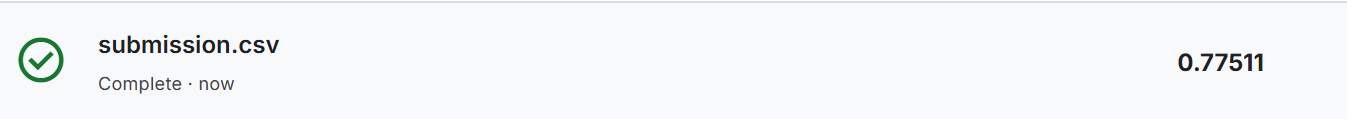